# 🚆 **Overview**

This notebook is dedicated to model development and experimentation. It covers model selection, training, hyperparameter tuning, feature importance analysis, and per-model evaluation. The workflow starts from merged raw training and test data combined with weather and solar irradiance datasets, which are then processed through a unified pipeline consisting of a custom imputer and feature engineering steps defined in `preprocessing.py`.

After preprocessing, models are trained within the pipeline, with a `TransformedTargetRegressor` wrapper applied to handle the highly skewed target distribution. Finally, the notebook evaluates model performance and visualizes feature importances to support model interpretability and comparison.

# 📚 **Library and Configuration**

This section configures the computational environment and loads all core dependencies used in the modeling workflow, including data processing, visualization, and machine learning libraries. The modeling framework is built on `scikit-learn` pipelines with `LightGBM` and `XGBoost` as the primary estimators, hyperparameter optimization handled by Optuna, and model performance evaluated using `Mean Squared Error` (MSE).

In [112]:
# System & Environment Configuration
import sys
import importlib
sys.path.append("..")

# Ignore warning
from warnings import filterwarnings
filterwarnings("ignore")

# Core Library
import numpy as np
import pandas as pd
import json
from pathlib import Path

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Models
import optuna
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Sklearn
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.compose import TransformedTargetRegressor

# Source helper
import src.modeling as modeling
import src.preprocessing as preprocessing

# Reload shortcut
def r(module=modeling):
    importlib.reload(module)

r(modeling)
r(preprocessing)

# Defaults
sns.set_style('whitegrid')
tscv = TimeSeriesSplit(n_splits=5)
optuna.logging.set_verbosity(optuna.logging.CRITICAL)

# Train and Test Processed
PROCESSED_ROOT = Path('../data/processed/')

TRAIN_PATH_PROCESSED = PROCESSED_ROOT/'train.csv'
TEST_PATH_PROCESSED = PROCESSED_ROOT/'test.csv'

# Figures Path
FIGURE_PATH = Path('../reports/figures')

print('library and configuration ready!')

library and configuration ready!


# 🗃️ **Train and Test Loading**

In [53]:
train = pd.read_csv(TRAIN_PATH_PROCESSED)
test = pd.read_csv(TEST_PATH_PROCESSED)

print('Train shape :', train.shape)
print('Test Shape  :', test.shape)

Train shape : (18942, 39)
Test Shape  : (1077, 39)


For clarity and ease of model training, the training dataset is separated into input features (`X`) and the target variable (`y`).

In [54]:
X = train.drop(columns=['% Baseline'])
y = train['% Baseline']

# ⚙️ **Model Tuning**

In the model tuning phase, we focus on XGBoost and LightGBM as the primary models, applying hyperparameter optimization with a time-aware train–validation strategy using `TimeSeriesSplit` to prevent data leakage. Each Optuna study is conducted with 100 trials to ensure a thorough exploration of the hyperparameter space.

To ensure reproducibility and avoid redundant hyperparameter tuning, the optimal model configurations obtained from Optuna are saved as JSON files. These stored parameters allow future model training and evaluation to be performed consistently without re-running the tuning process.

In [ ]:
def save_params(
    study,
    best_path: Path,
    sample_path: Path,
    metric_name: str = "mse",
    lower_is_better: bool = True
):
    current_result = {
        metric_name: study.best_value,
        "params": study.best_params,
        "n_trials": len(study.trials)
    }

    if not best_path.exists():
        with open(best_path, "w") as f:
            json.dump(current_result, f, indent=2)
        print("Saved as best parameters (no previous record).")
        return

    with open(best_path, "r") as f:
        previous_result = json.load(f)

    prev_score = previous_result[metric_name]
    curr_score = current_result[metric_name]

    is_better = curr_score < prev_score if lower_is_better else curr_score > prev_score

    if is_better:
        with open(best_path, "w") as f:
            json.dump(current_result, f, indent=2)
        print(
            f"New best found! {metric_name.upper()} improved "
            f"from {prev_score:.5f} -> {curr_score:.5f}"
        )
    else:
        with open(sample_path, "w") as f:
            json.dump(current_result, f, indent=2)
        print(
            f"No improvement ({metric_name.upper()}: {curr_score:.5f}). "
            "Saved as sample."
        )

## **XGBoost** 

In [ ]:
def xgb_objective(trial):

    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.15),
        "n_estimators": trial.suggest_int("n_estimators", 300, 800),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.5, 3.0),
    }

    base_model = XGBRegressor(**params)

    model = TransformedTargetRegressor(
        regressor=base_model,
        func=np.cbrt,
        inverse_func=lambda x: x**3
    )

    pipeline = Pipeline(steps=[
        ("solar_imputer", preprocessing.SolarImputer()),
        ("feature_engineering", preprocessing.FeatureEngineering(
            n_clusters=4,
            stl_period=24
        )),
        ("scaler", StandardScaler()),
        ("model", model)
    ])

    scores = []

    for train_idx, val_idx in tscv.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_val)

        scores.append(mean_squared_error(y_val, y_pred))

    return np.mean(scores)


study_xgb = optuna.create_study(direction="minimize")
study_xgb.optimize(xgb_objective, n_trials=100, show_progress_bar=True)

print("Best MSE:", study_xgb.best_value)
print("Best Params:", study_xgb.best_params)

  0%|          | 0/100 [00:00<?, ?it/s]

Best MSE: 0.010540914144682351
Best Params: {'max_depth': 7, 'learning_rate': 0.013911576874104293, 'n_estimators': 339, 'subsample': 0.7576620887269937, 'colsample_bytree': 0.6328389192809319, 'min_child_weight': 7, 'reg_alpha': 0.22650072332487522, 'reg_lambda': 1.388606519343097}


In [ ]:
save_best_optuna_study(
    study=study_xgb,
    best_path=Path("../models/config/xgb_best_params.json"),
    sample_path=Path("../models/config/xgb_best_params_sample.json"),
    metric_name="mse",
    lower_is_better=True
)

No improvement (MSE: 0.01054). Saved as sample.


In [97]:
with open("../models/config/xgb_best_params.json", "r") as f:
    xgb_result = json.load(f)

base_model_xgb = XGBRegressor(
    **xgb_result["params"]
)

model_xgb = TransformedTargetRegressor(
    regressor=base_model_xgb,
    func=np.cbrt,
    inverse_func=lambda x: x**3
)

pipeline_xgb = Pipeline(steps=[
    ("solar_imputer", preprocessing.SolarImputer()),
    ("feature_engineering", preprocessing.FeatureEngineering(
        n_clusters=4,
        stl_period=24
    )),
    ("scaler", StandardScaler()),
    ("model", model_xgb)
])

pipeline_xgb.fit(X, y)

Pipeline(steps=[('solar_imputer', SolarImputer()),
                ('feature_engineering', FeatureEngineering()),
                ('scaler', StandardScaler()),
                ('model',
                 TransformedTargetRegressor(func=<ufunc 'cbrt'>,
                                            inverse_func=<function <lambda> at 0x000001D42784CF40>,
                                            regressor=XGBRegressor(base_score=None,
                                                                   booster=None,
                                                                   callbacks=None,
                                                                   colsample_bylevel=None,
                                                                   colsample_bynode=None,
                                                                   colsample...
                                                                   gamma=None,
                                                                   grow_policy=None,
                                                                   importance_type=None,
                                                                   interaction_constraints=None,
                                                                   learning_rate=0.013911576874104293,
                                                                   max_bin=None,
                                                                   max_cat_threshold=None,
                                                                   max_cat_to_onehot=None,
                                                                   max_delta_step=None,
                                                                   max_depth=7,
                                                                   max_leaves=None,
                                                                   min_child_weight=7,
                                                                   missing=nan,
                                                                   monotone_constraints=None,
                                                                   multi_strategy=None,
                                                                   n_estimators=339,
                                                                   n_jobs=None,
                                                                   num_parallel_tree=None, ...)))])

In [95]:
print('XGBoost Timeseries KFold Test')

X = train.drop(columns=['% Baseline'])
y = train['% Baseline']

mse_scores_xgb = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    pipeline_xgb.fit(X_train, y_train)
    y_pred = pipeline_xgb.predict(X_val)

    mse = mean_squared_error(y_val, y_pred)
    mse_scores_xgb.append(mse)

    print(f"Fold {fold+1} \t MSE: {mse:.4f}")

print(f"\nXGBoost Cross-validation MSE: {np.mean(mse_scores_xgb):.4f}")

XGBoost Timeseries KFold Test
Fold 1 	 MSE: 0.0142
Fold 2 	 MSE: 0.0115
Fold 3 	 MSE: 0.0107
Fold 4 	 MSE: 0.0065
Fold 5 	 MSE: 0.0098

XGBoost Cross-validation MSE: 0.0105


## **LGBM Training**

In [ ]:
def lgbm_objective(trial):

    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.15),
        "n_estimators": trial.suggest_int("n_estimators", 500, 2000),

        "num_leaves": trial.suggest_int("num_leaves", 20, 80),
        "max_depth": trial.suggest_int("max_depth", 4, 10),

        "min_child_samples": trial.suggest_int("min_child_samples", 20, 100),
        "min_child_weight": trial.suggest_float("min_child_weight", 1e-3, 10.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.5, 3.0),

        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),

        "random_state": 42,
        "verbose": -1,
        "n_jobs": -1
    }

    base_model = LGBMRegressor(**params)

    model = TransformedTargetRegressor(
        regressor=base_model,
        func=np.cbrt,
        inverse_func=lambda x: x**3
    )

    pipeline = Pipeline(steps=[
        ("solar_imputer", preprocessing.SolarImputer()),
        ("feature_engineering", preprocessing.FeatureEngineering(
            n_clusters=4,
            stl_period=24
        )),
        ("scaler", StandardScaler()),
        ("model", model)
    ])

    scores = []

    for train_idx, val_idx in tscv.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_val)

        scores.append(mean_squared_error(y_val, y_pred))

    return np.mean(scores)


study_lgbm = optuna.create_study(direction="minimize")
study_lgbm.optimize(lgbm_objective, n_trials=100, show_progress_bar=True)

print("Best MSE:", study_lgbm.best_value)
print("Best Params:", study_lgbm.best_params)

  0%|          | 0/100 [00:00<?, ?it/s]

Best MSE: 0.010665586300320789
Best Params: {'learning_rate': 0.01353521009621635, 'n_estimators': 534, 'num_leaves': 34, 'max_depth': 8, 'min_child_samples': 27, 'min_child_weight': 1.3459119926157737, 'reg_alpha': 0.9665358128700258, 'reg_lambda': 1.2040653570705673, 'subsample': 0.799849906087852, 'colsample_bytree': 0.609184564029643}


In [ ]:
# Save LGBM Result
save_best_optuna_study(
    study=study_lgbm,
    best_path=Path("../models/config/lgbm_best_params.json"),
    sample_path=Path("../models/config/lgbm_best_params_sample.json"),
    metric_name="mse",
    lower_is_better=True
)

No improvement (MSE: 0.01067). Saved as sample.


In [ ]:
with open("../models/config/lgbm_best_params.json", "r") as f:
    lgbm_result = json.load(f)


base_model_lgbm = LGBMRegressor(
    **lgbm_result['params']
)

model_lgbm = TransformedTargetRegressor(
    regressor=base_model_lgbm,
    func=np.cbrt,
    inverse_func=lambda x: x**3
)

pipeline_lgbm = Pipeline(steps=[
    ("solar_imputer", preprocessing.SolarImputer()),
    ("feature_engineering", preprocessing.FeatureEngineering(
        n_clusters=4,
        stl_period=24
    )),
    ("scaler", StandardScaler()),
    ("model", model_lgbm)
])

pipeline_lgbm.fit(X, y)

Pipeline(steps=[('solar_imputer', SolarImputer()),
                ('feature_engineering', FeatureEngineering()),
                ('scaler', StandardScaler()),
                ('model',
                 TransformedTargetRegressor(func=<ufunc 'cbrt'>,
                                            inverse_func=<function <lambda> at 0x000001D42784A200>,
                                            regressor=LGBMRegressor(colsample_bytree=0.609184564029643,
                                                                    learning_rate=0.01353521009621635,
                                                                    max_depth=8,
                                                                    min_child_samples=27,
                                                                    min_child_weight=1.3459119926157737,
                                                                    n_estimators=534,
                                                                    num_leaves=34,
                                                                    reg_alpha=0.9665358128700258,
                                                                    reg_lambda=1.2040653570705673,
                                                                    subsample=0.799849906087852)))])

In [ ]:
print('LightGBM Timeseries KFold Test')

mse_scores_lgbm = []
for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    pipeline_lgbm.fit(X_train, y_train)
    y_pred = pipeline_lgbm.predict(X_val)

    mse = mean_squared_error(y_val, y_pred)
    mse_scores_lgbm.append(mse)

    print(f"Fold {fold+1} \t MSE: {mse:.4f}")

print(f"\nXGBoost Cross-validation MSE: {np.mean(mse_scores_lgbm):.4f}")

LightGBM Timeseries KFold Test
Fold 1 	 MSE: 0.0152
Fold 2 	 MSE: 0.0118
Fold 3 	 MSE: 0.0107
Fold 4 	 MSE: 0.0063
Fold 5 	 MSE: 0.0100

XGBoost Cross-validation MSE: 0.0108


# 📈 **Inference**

The trained pipeline is applied to the competition test set to generate final predictions, ensuring that all preprocessing and feature engineering steps remain consistent with the training phase. These predictions are then formatted according to the competition submission requirements.

In [ ]:
pipeline_xgb.fit(X, y)
pipeline_lgbm.fit(X, y)

preds_xgb = pipeline_xgb.predict(test.drop(columns=['% Baseline']))
preds_lgbm = pipeline_lgbm.predict(test.drop(columns=['% Baseline']))

preds = (preds_xgb+preds_lgbm)/2

test['% Baseline'] = preds
submission = test[['Timestamp', '% Baseline']]
submission["Timestamp"] = (
    pd.to_datetime(submission["Timestamp"])
    .dt.strftime("%b %d, %Y %I%p")
    .str.lstrip("0")
    .str.replace(" 0", " ", regex=False)
    .str.capitalize()
    .str.strip()
)

submission.to_csv('../models/inference/submission_sample.csv', index = False)
print(submission.head())

          Timestamp  % Baseline
0   Oct 1, 2017 6am    0.032302
1   Oct 1, 2017 7am    0.058684
2   Oct 1, 2017 8am    0.132367
3   Oct 1, 2017 9am    0.349197
4  Oct 1, 2017 10am    0.519322


# 🔧 **Feature Importances**

Re-training with full dataset
Model successfully trained!


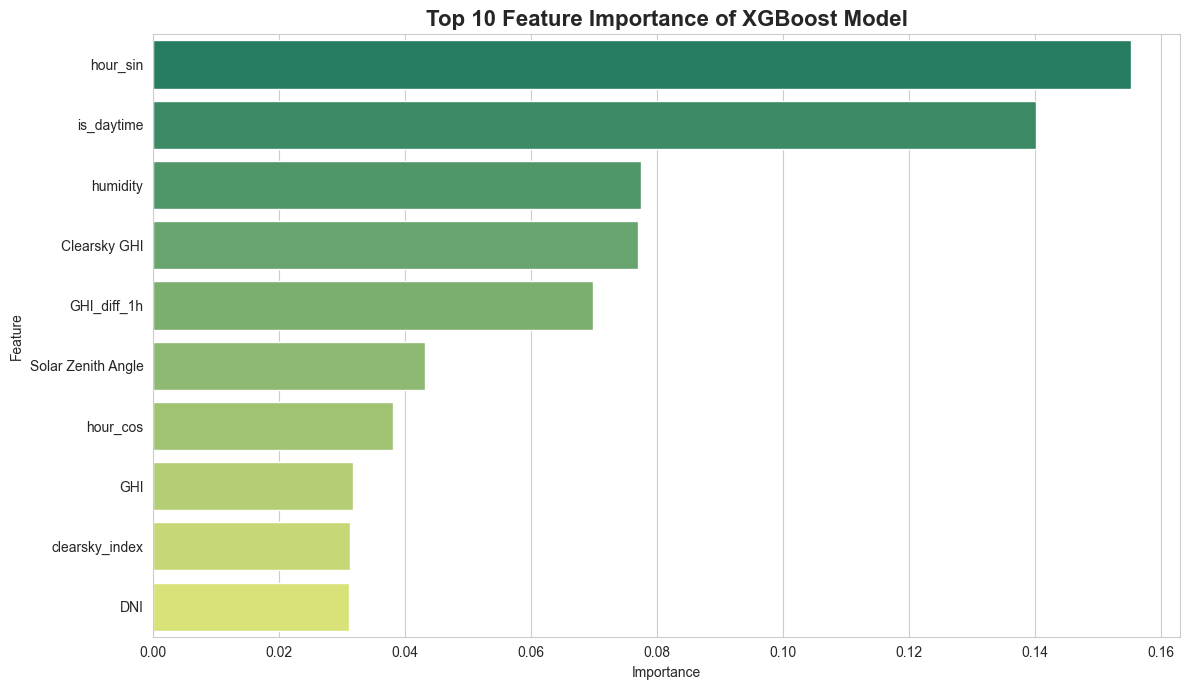

In [127]:
print("Re-training with full dataset")
pipeline_xgb.fit(X, y)
print("Model successfully trained!")

modeling.plot_importance(
    pipeline_xgb, X, name="XGBoost", top_n=10, palette='summer',
    save_path=FIGURE_PATH/'model_eval/xgb_feature_importances.png'
)

### **XGBoost Model Interpretation**

The XGBoost model is strongly driven by **diurnal time structure**, with `hour_sin` and `is_daytime` emerging as the most important features. This indicates that the model relies heavily on the daily solar cycle to explain variations in energy output, effectively learning when solar generation is physically possible and how it evolves throughout the day.

Secondary features such as `humidity`, `Clearsky GHI`, `Solar Zenith Angle`, and `GHI_diff_1h` act as **local correction factors**. These variables help the model adjust the idealized diurnal pattern to real atmospheric conditions and short-term fluctuations, suggesting that XGBoost is particularly sensitive to **short-term dynamics and intraday variability**.

Re-training with full dataset
Model successfully trained!


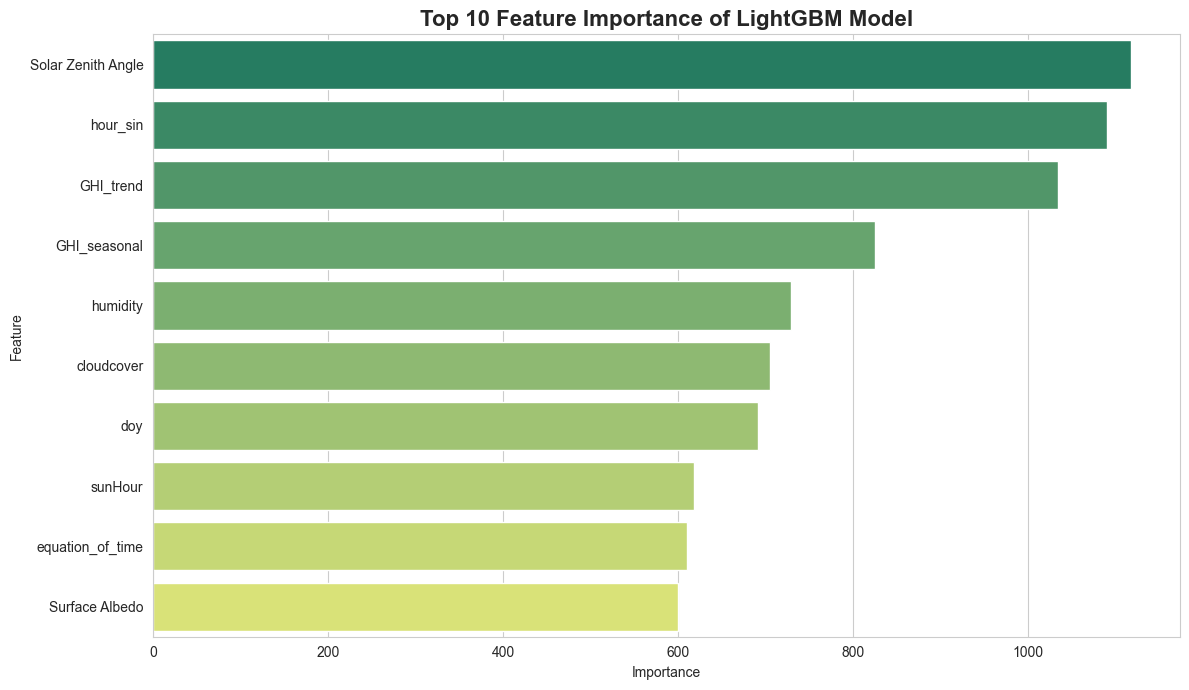

In [125]:
print("Re-training with full dataset")
pipeline_lgbm.fit(X, y)
print("Model successfully trained!")

modeling.plot_importance(
    pipeline_lgbm, X,
    name="LightGBM", top_n=10,
    palette='summer',
    save_path=FIGURE_PATH/'model_eval/lgbm_feature_importances.png'
)

### **LightGBM Model Interpretation**

In contrast, the LightGBM model places the highest importance on **Solar Zenith Angle**, followed by `hour_sin`, highlighting a stronger reliance on **physical and geometric drivers** of solar irradiance rather than purely temporal indicators. This suggests that LightGBM captures the underlying solar geometry more explicitly when modeling energy output.

Additionally, the prominence of `GHI_trend`, `GHI_seasonal`, `doy`, and `equation_of_time` shows that LightGBM effectively models **medium- to long-term seasonal structure** in the data. Weather-related features like `humidity` and `cloudcover` serve as adjustments on top of this stable seasonal backbone, indicating that LightGBM prioritizes **structural consistency and seasonal patterns** over short-term noise.
